In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scanpy as sc

from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hs
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.base import gunzip
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from adjustText import adjust_text

In [2]:
genes_of_interest_path = (
    "/home/t.afanasyeva/MATseq/notebooks/DeSeq2/immuno_gene_symbols.txt"
)
immunoresponse_gene_df = pd.read_csv(genes_of_interest_path, sep="\t")
immunoresponse_genes = list(immunoresponse_gene_df["Approved symbol"])

In [ ]:
def deseq(
    analysis_name,
    counts,
    metadata,
    classes_to_include,
    padj_value=0.05,
    log2foldchange_value=1,
):
    dds = DeseqDataSet(counts=counts, metadata=metadata, design_factors="Condition")
    dds.deseq2()

    sns.set_theme(context="notebook", style="white")

    sc.tl.pca(dds)
    sc.pl.pca(dds, color="Condition", size=200, save=f"_{analysis_name}.png")

    stat_res = DeseqStats(dds, contrast=("Condition", *classes_to_include))
    stat_res.summary()
    res = stat_res.results_df
    res = res[res.baseMean >= 10]
    sigs = res[
        (res.padj < padj_value) & (abs(res.log2FoldChange) > log2foldchange_value)
    ]

    return (dds, res, sigs)

In [3]:
def prepare_counts_metadata(counts, classes):
    filtered_counts = counts[counts["class"].isin(classes)]
    metadata = filtered_counts["class"]
    metadata = metadata.to_frame(name="Condition")

    filtered_counts = filtered_counts.drop("class", axis=1)
    filtered_counts = filtered_counts.T[filtered_counts.T.mean(axis=1) > 10].T

    return filtered_counts, metadata

In [94]:
def make_historgram_for_sign_genes(
    dds, sigs, results_directory, analysis_name, num_top_sign
):
    if num_top_sign != "all":
        sigs = sigs.sort_values("padj")[:num_top_sign]

    dds_sigs = dds[:, sigs.index]
    dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])

    grapher = pd.DataFrame(
        dds_sigs.layers["log1p"].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names
    )

    plt.figure(figsize=(12, 12))
    sns.set_theme(
        context="notebook",
        style="darkgrid",
        palette="deep",
        font="sans-serif",
        font_scale=0.55,
        color_codes=True,
        rc=None,
    )

    sns.clustermap(grapher, z_score=0, cmap="RdYlBu_r")
    plt.title(analysis_name)

    plt.savefig(
        f"{results_directory}/{analysis_name}_histo_sign.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

In [90]:
def initialise_go():
    # obo_fname = download_go_basic_obo() # Already downloaded the go-basic.obo
    # fin_gene2go = gunzip("gene2go.gz") # Already unzipped the file

    fin_gene2go = "gene2go"
    obodag = GODag("go-basic.obo")

    mapper = {}
    for key in GeneID2nt_hs:
        mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID

    objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

    """
    Get namespace2association where:
       namespace is:
           BP: biological_process
           MF: molecular_function
           CC: cellular_component
       assocation is a dict:
           key: NCBI GeneID
           value: A set of GO IDs associated with that gene
    """
    ns2assoc = objanno.get_ns2assc()

    goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(),  # List of human protein-coding genes
        ns2assoc,  # Geneid/GO associations
        obodag,  # Ontologies
        propagate_counts=False,
        alpha=0.05,  # Default significance cut-off
        methods=["fdr_bh"],  # Default multipletest correction method
    )

    go_items = []

    temp = goeaobj.ns2objgoea["BP"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["CC"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["MF"].assoc
    for item in temp:
        go_items += temp[item]

    return mapper, goeaobj, go_items


def go_it(test_genes, mapper, goeaobj, go_items):
    print(f"input genes: {len(test_genes)}")

    inv_map = {v: k for k, v in mapper.items()}

    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f"mapped genes: {len(mapped_genes)}")

    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

    GO = pd.DataFrame(
        list(
            map(
                lambda x: [
                    x.GO,
                    x.goterm.name,
                    x.goterm.namespace,
                    x.p_uncorrected,
                    x.p_fdr_bh,
                    x.ratio_in_study[0],
                    x.ratio_in_study[1],
                    go_items.count(x.GO),
                    list(map(lambda y: inv_map[y], x.study_items)),
                    x.ratio_in_study[0] / go_items.count(x.GO),
                ],
                goea_results_sig,
            )
        ),
        columns=[
            "GO",
            "term",
            "class",
            "p",
            "p_corr",
            "n_genes",
            "n_study",
            "n_go",
            "study_genes",
            "per",
        ],
    )

    GO = GO[GO.n_genes > 1]
    return GO


def make_go_plot(df, results_directory, analysis_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = mpl.cm.bwr_r
    norm = mpl.colors.Normalize(vmin=df.p_corr.min(), vmax=df.p_corr.max())
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    sns.barplot(
        data=df,
        x="per",
        y="term",
        palette=list(mapper.to_rgba(df.p_corr.values)),
        ax=ax,
    )
    ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])

    cbar = fig.colorbar(mapper, ax=ax, orientation="vertical", pad=0.01)
    cbar.ax.set_position([0.8, 0.5, 0.2, 0.3])
    plt.title(analysis_name)

    plt.savefig(
        f"{results_directory}/{analysis_name}_go.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )


mapper, goeaobj, go_items = initialise_go()

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms
HMS:0:00:52.096511 345,172 annotations, 20,754 genes, 18,774 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
 82% 17,005 of 20,615 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,132 of 20,615 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,589 of 20,615 population items found in association


In [92]:
def map_color(gene, overexpressed, underexpressed):
    if gene in overexpressed:
        return "overexpressed"
    elif gene in underexpressed:
        return "underexpressed"
    else:
        return "no_expression_change"


def map_shape(gene, immunoresponse_genes):
    if gene in immunoresponse_genes:
        return "immunoresponse"
    else:
        return "no_immunoresponse"


def make_volcano_plot(
    res,
    genes_of_interest,
    results_directory,
    analysis_name,
    sign_log2FoldChange=2,
    sign_padj=0.05,
):
    sign_genes = res[(res["padj"] < sign_padj)]
    overexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] > sign_log2FoldChange)].index
    )
    underexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] < -sign_log2FoldChange)].index
    )

    df = res.reset_index(names="gene")
    df["padj_log"] = -np.log10(df["padj"])

    df["color"] = df.apply(
        lambda row: map_color(row["gene"], overexpressed, underexpressed),
        axis=1,
    )

    df["shape"] = df.apply(
        lambda row: map_shape(row["gene"], genes_of_interest),
        axis=1,
    )

    plt.figure(figsize=(10, 12))
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(context="notebook", style="white", rc=custom_params)
    plt.title(analysis_name)

    ax = sns.scatterplot(
        data=df,
        x="log2FoldChange",
        y="padj_log",
        hue="color",
        hue_order=["no_expression_change", "overexpressed", "underexpressed"],
        palette=["grey", "orange", "purple"],
        style="shape",
        style_order=["immunoresponse", "no_immunoresponse"],
        markers=["s", "o"],
        size="baseMean",
        sizes=(20, 200),
    )

    ax.axhline(1.3, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(2, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(-2, zorder=1, c="k", lw=1, ls="--")

    ax.tick_params(width=2)

    texts = []
    for i in range(len(df)):
        if (
            df.iloc[i].padj < sign_padj
            and abs(df.iloc[i].log2FoldChange) > sign_log2FoldChange
        ):
            texts.append(
                plt.text(
                    x=df.iloc[i].log2FoldChange,
                    y=df.iloc[i].padj_log,
                    s=df.iloc[i].gene,
                    fontsize=10,
                    weight="bold",
                )
            )

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k"))
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1), frameon=False, prop={"weight": "bold"})

    plt.xticks(size=10, weight="bold")
    plt.yticks(size=10, weight="bold")

    plt.xlabel("$log_{2}$ fold change")
    plt.ylabel("-$log_{10}$ FDR")

    plt.savefig(
        f"{results_directory}/{analysis_name}_volcano.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

In [66]:
file_path = "gene_counts_all_batches_157_samples_deseq2.csv"
raw_counts = pd.read_csv(file_path, index_col="sample")

In [78]:
list_of_classes_to_include = []
for my_class in raw_counts["class"].unique():
    if my_class != "IMDM":
        list_of_classes_to_include.append([my_class, "IMDM"])

In [79]:
list_of_classes_to_include

[['Fla-St', 'IMDM'],
 ['LPS', 'IMDM'],
 ['Pam3', 'IMDM'],
 ['R848', 'IMDM'],
 ['CL-307', 'IMDM'],
 ['CRX-527', 'IMDM'],
 ['Fla-PA', 'IMDM'],
 ['R848-low', 'IMDM'],
 ['LTA-BS', 'IMDM']]

In [80]:
list_of_classes_to_include.pop(-1)

['LTA-BS', 'IMDM']

In [69]:
current_directory = os.getcwd()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.18 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 1.23 seconds.

Fitting LFCs...


... done in 1.96 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


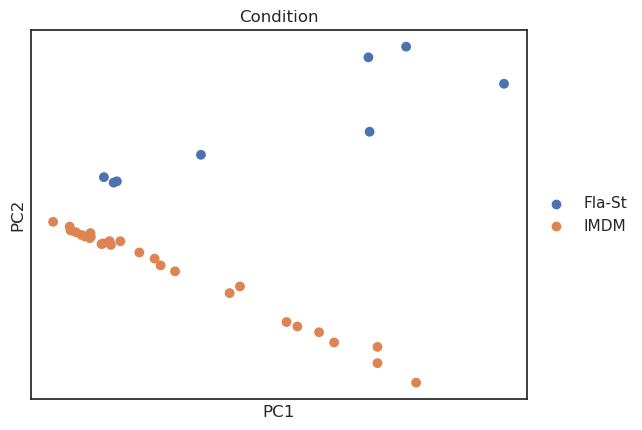

Running Wald tests...
... done in 1.12 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition Fla-St vs IMDM
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
KLHL8     83.524094        0.242078  0.123017  1.967839  0.049087  0.125837
ZNF576    41.540111        0.007751  0.122246  0.063407  0.949442  0.970581
FCF1     223.963035        0.036595  0.110158  0.332206  0.739734  0.843340
TAF12     74.890028        0.150968  0.126935  1.189333  0.234309  0.396725
GLRX      61.681922        0.236114  0.134675  1.753219  0.079564  0.180575
...             ...             ...       ...       ...       ...       ...
TSN      320.995949       -0.007427  0.069240 -0.107259  0.914584  0.951639
NFATC1   330.326159       -0.063402  0.073400 -0.863788  0.387704  0.560595
PORCN     25.429830        0.119081  0.157440  0.756356  0.449436  0.618073
REL     1895.223008        0.317128  0.088715  3.574673  0.000351  0.001938
RPL23   2595.386421        0.156515  0.095805  1.633681  0.102326  0.218103

[11754 rows x 6 columns]

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/matplotlib/transforms.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.11 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 1.19

... done in 0.03 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

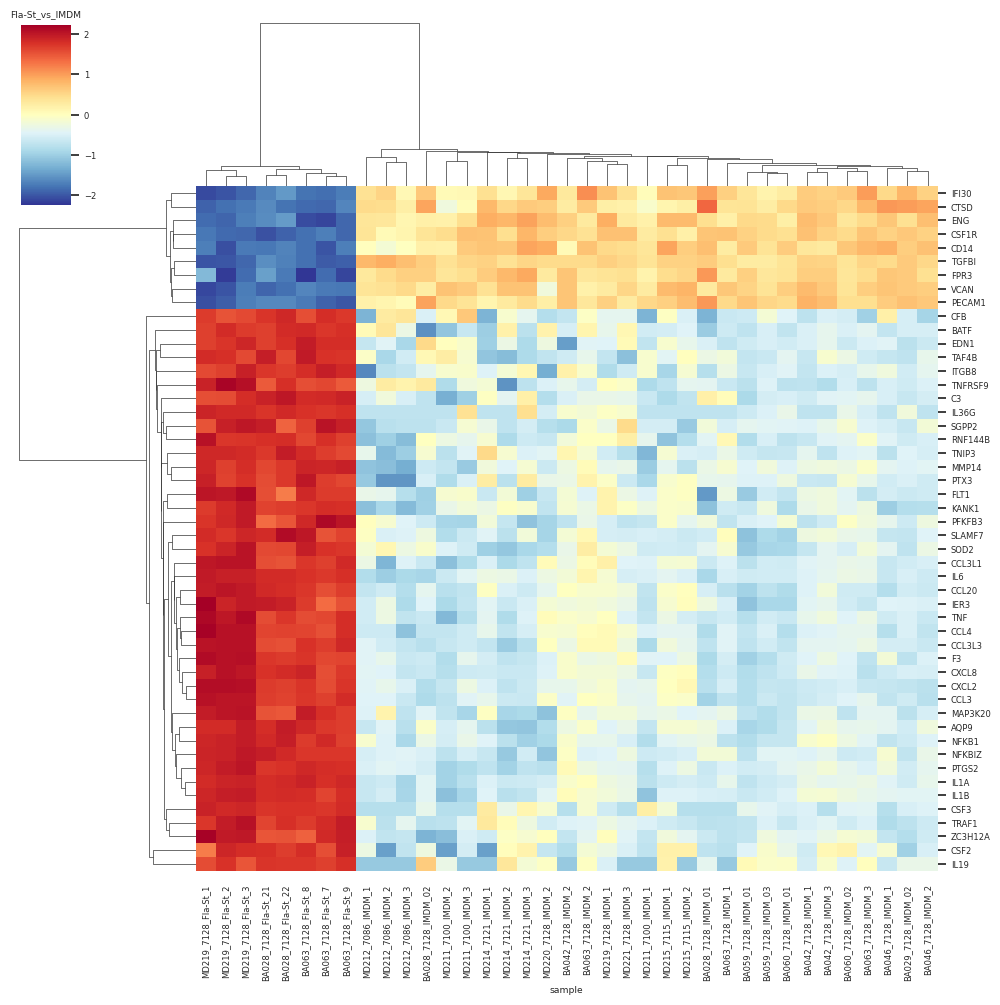

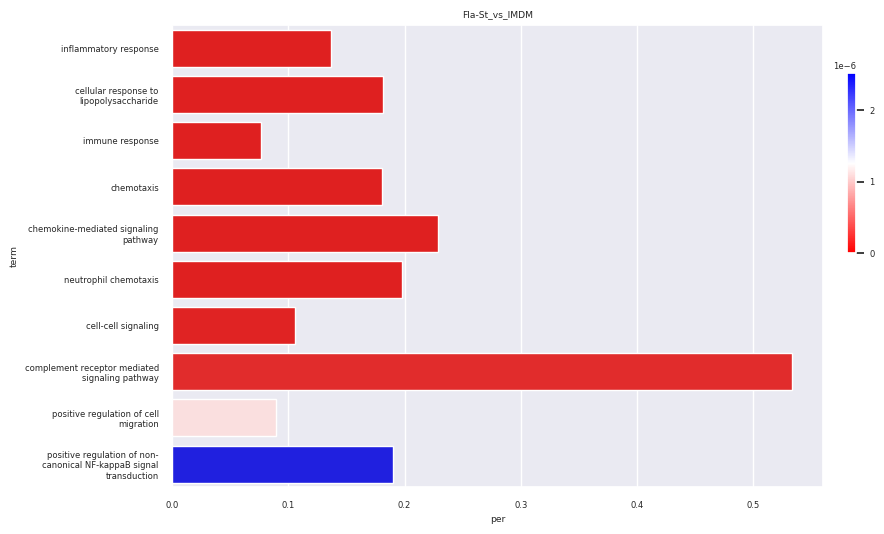

posx and posy should be finite values
posx and posy should be finite values


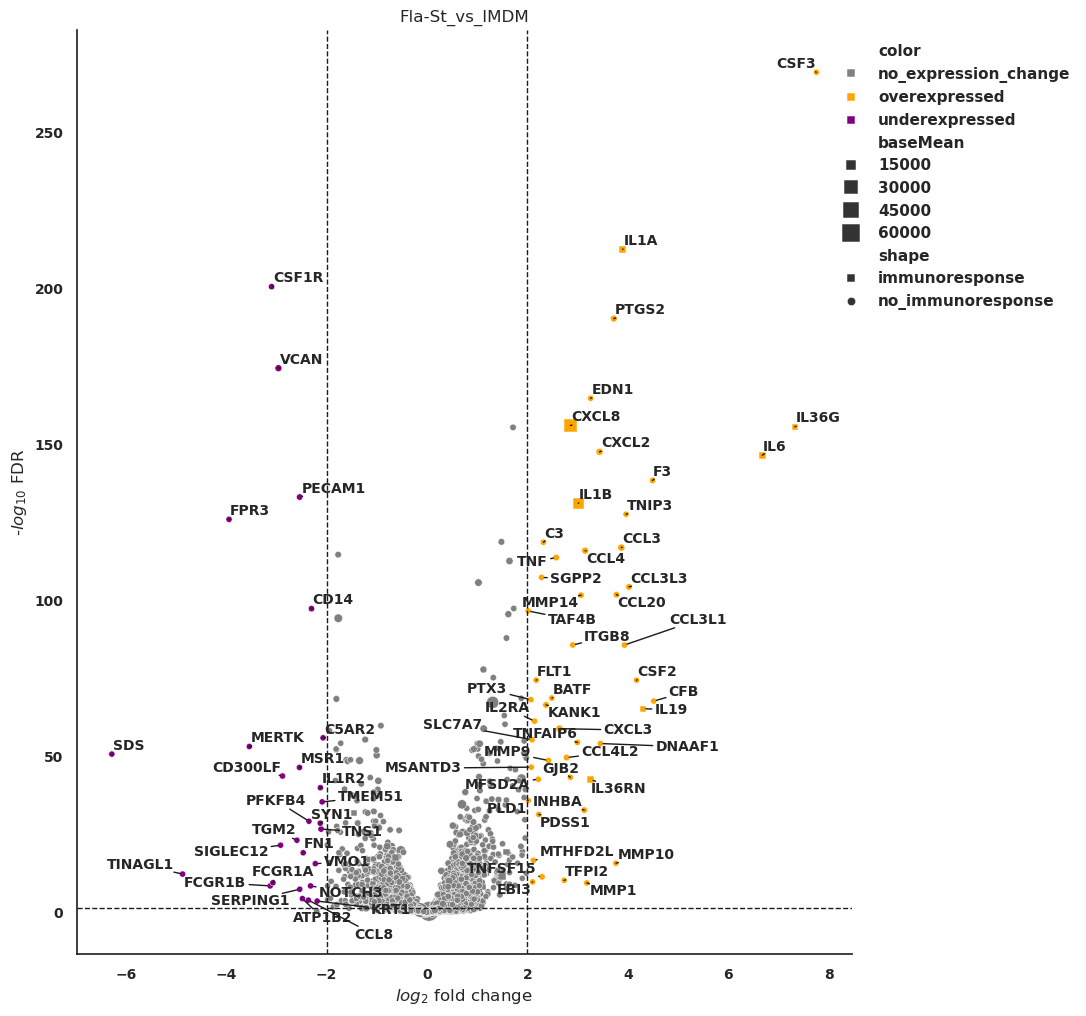

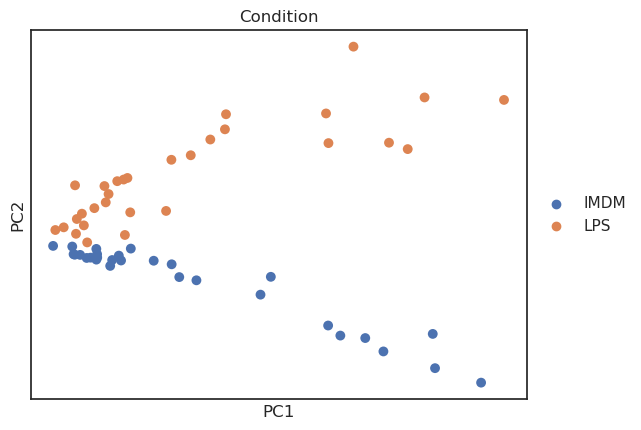

Running Wald tests...
... done in 1.21 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition LPS vs IMDM
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
KLHL8     80.932322        0.287572  0.072860  3.946928  7.916042e-05   
ZNF576    38.051087        0.015425  0.089304  0.172723  8.628694e-01   
FCF1     195.651725       -0.051423  0.070359 -0.730861  4.648640e-01   
TAF12     63.870366       -0.076569  0.085012 -0.900688  3.677542e-01   
GLRX      69.173586        0.631972  0.076502  8.260859  1.446284e-16   
...             ...             ...       ...       ...           ...   
TSN      286.545544       -0.024028  0.057593 -0.417195  6.765359e-01   
NFATC1   297.074272       -0.017882  0.060350 -0.296301  7.670006e-01   
PORCN     23.263255        0.085830  0.110397  0.777470  4.368817e-01   
REL     1760.515406        0.230415  0.069449  3.317778  9.073666e-04   
RPL23   2246.702888       -0.037591  0.081164 -0.463151  6.432561e-01   

                padj  
KLHL8   8.013523e-04  
ZNF576  9.422730e

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.13 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 1.19 seconds.

Fitting LFCs...
... done in 1.68 seconds.

Refitting 17 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

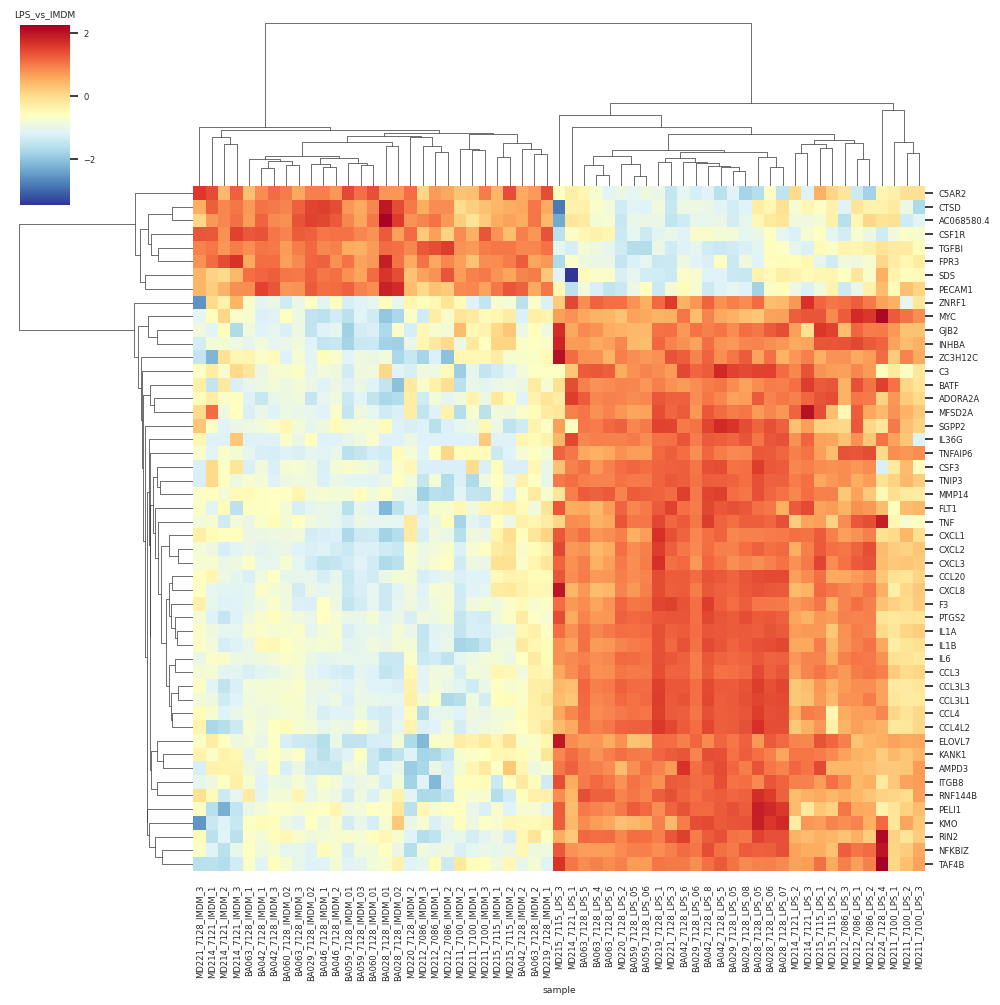

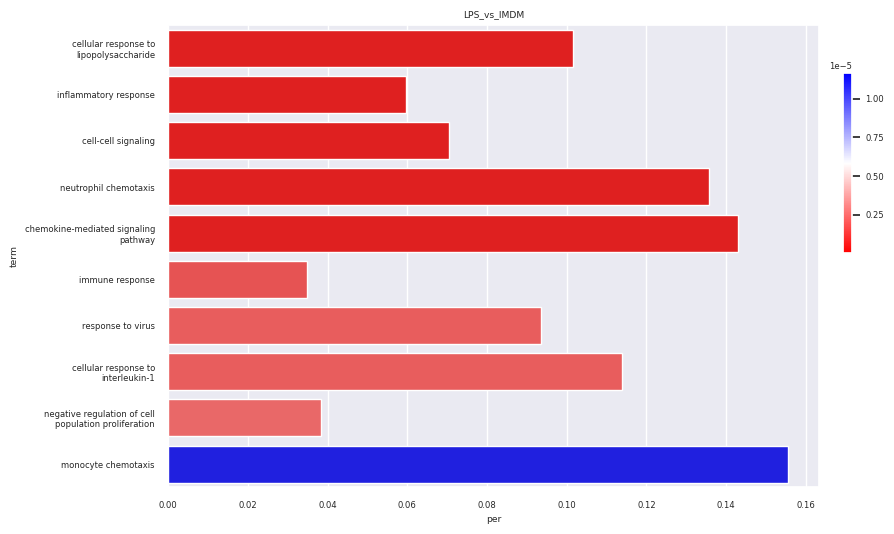

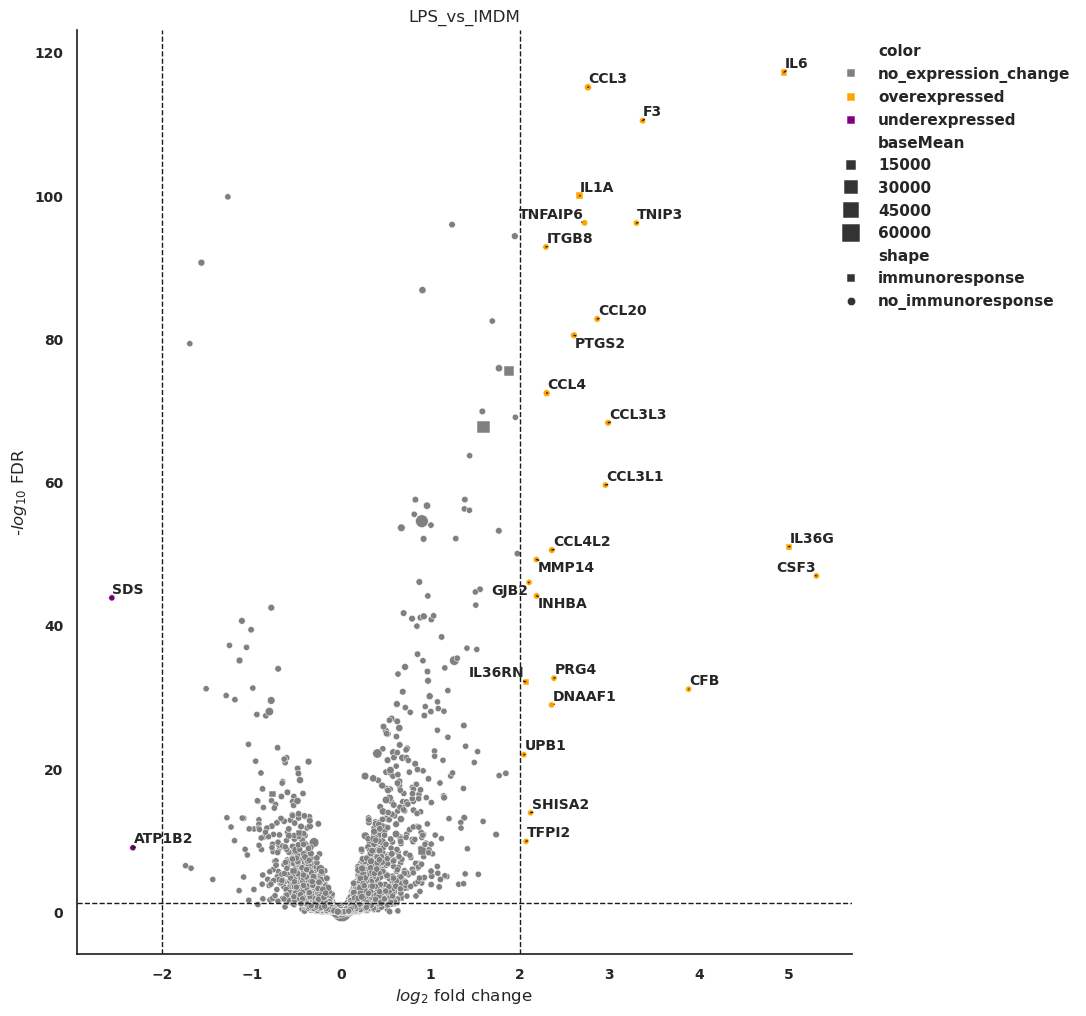

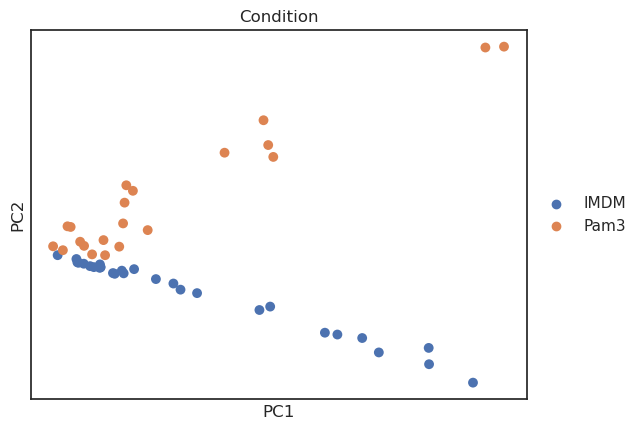

Running Wald tests...
... done in 1.16 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition Pam3 vs IMDM
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
KLHL8     75.236113        0.422600  0.100276  4.214352  0.000025  0.000187
ZNF576    32.268684       -0.115369  0.103093 -1.119071  0.263110  0.443848
FCF1     176.746551       -0.045983  0.089140 -0.515851  0.605958  0.758190
TAF12     59.184354       -0.024118  0.096376 -0.250247  0.802396  0.890660
GLRX      53.997338        0.378375  0.118249  3.199809  0.001375  0.006817
...             ...             ...       ...       ...       ...       ...
TSN      263.776411        0.057485  0.051019  1.126732  0.259856  0.440827
NFATC1   268.037772       -0.002417  0.061830 -0.039088  0.968820  0.982062
PORCN     18.677919       -0.238914  0.135854 -1.758615  0.078643  0.186546
REL     1629.803559        0.366137  0.083264  4.397296  0.000011  0.000088
RPL23   2097.700927        0.085186  0.067260  1.266511  0.205330  0.375600

[11495 rows x 6 columns]
i

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.13 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 1.17 seconds.

Fitting LFCs...
... done in 1.09 seconds.

Refitting 4 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

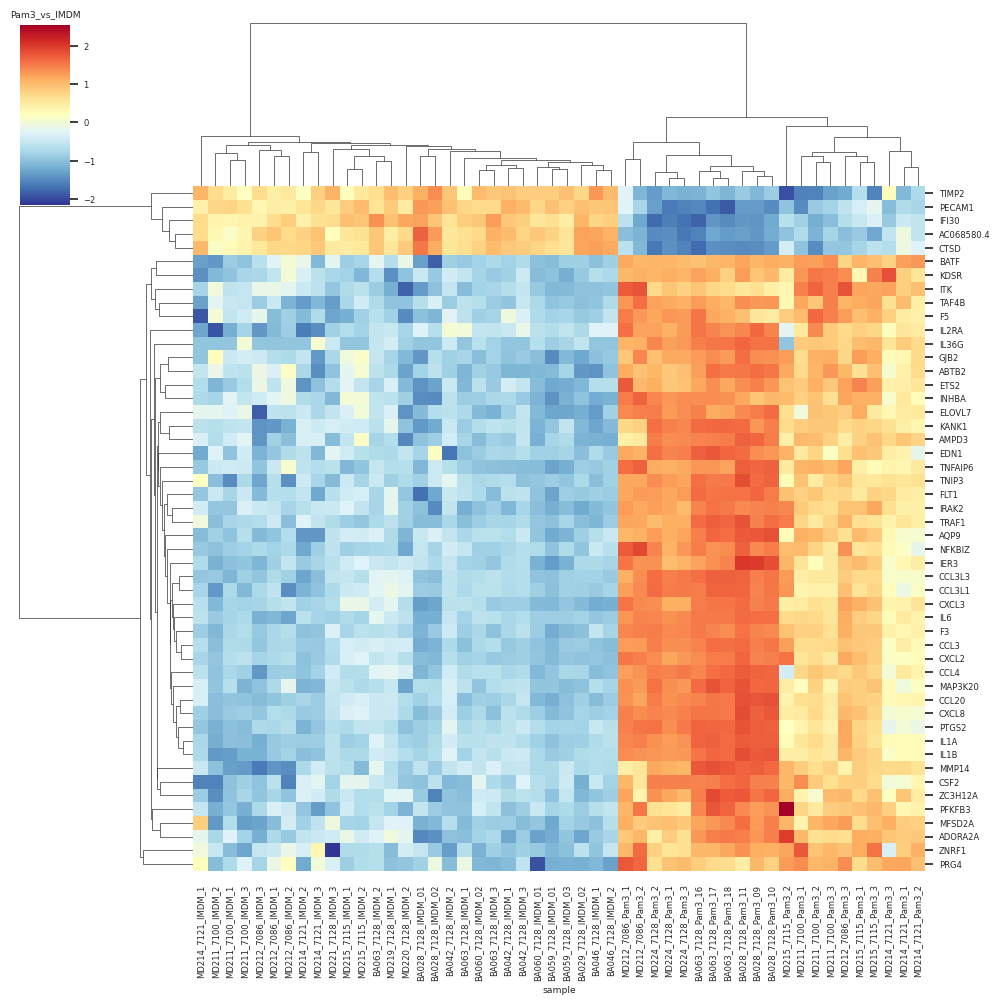

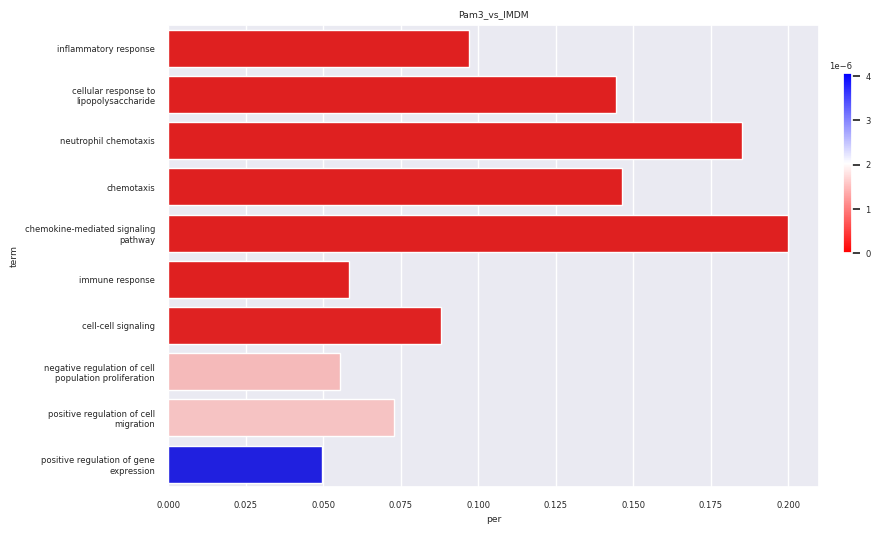

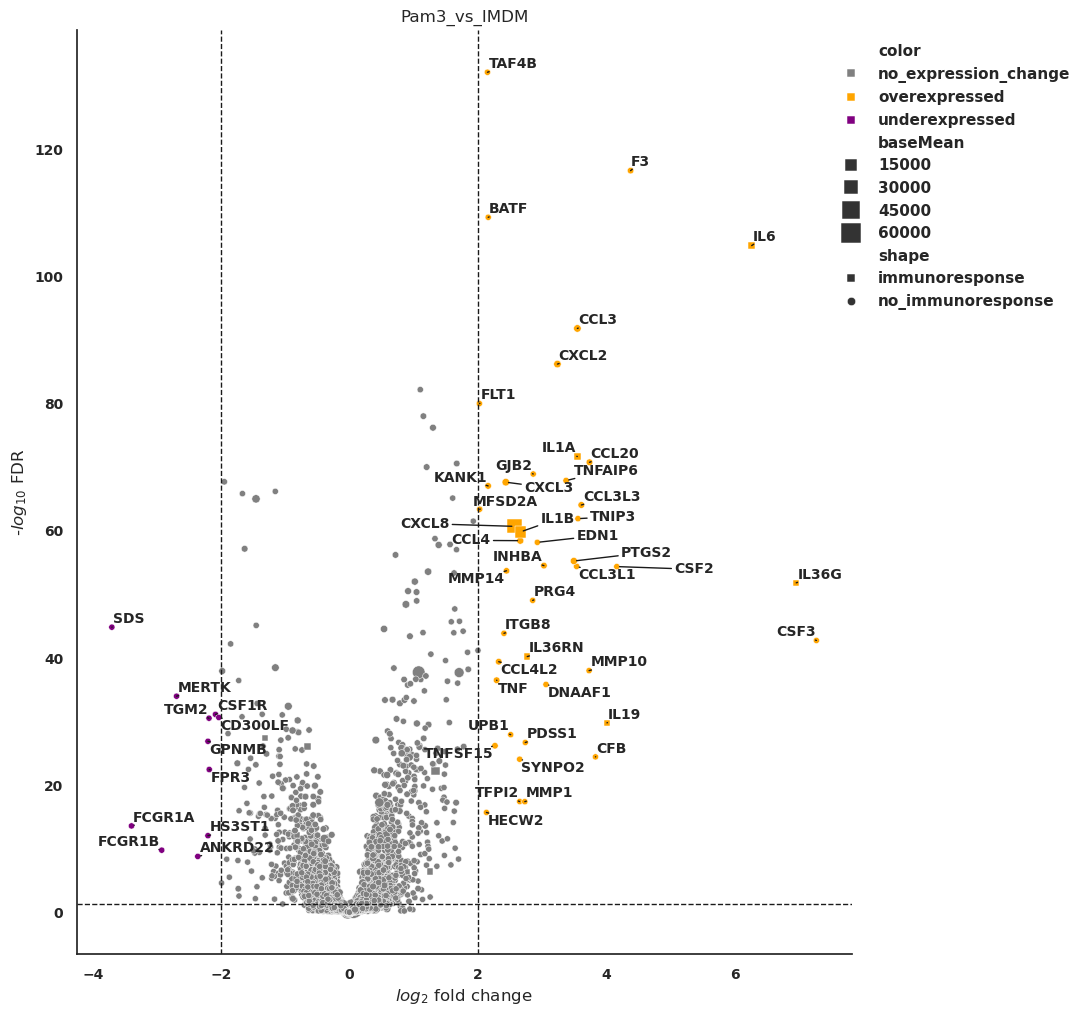

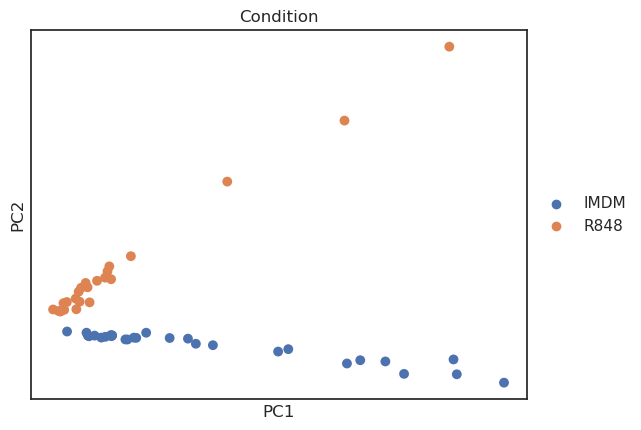

Running Wald tests...
... done in 1.16 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition R848 vs IMDM
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
KLHL8     61.968233        0.549248  0.098662  5.566992  2.591747e-08   
ZNF576    26.523887       -0.000063  0.117476 -0.000532  9.995751e-01   
FCF1     139.715339       -0.010334  0.090026 -0.114791  9.086106e-01   
TAF12     42.548084       -0.270215  0.107939 -2.503392  1.230091e-02   
GLRX      54.853587        1.023201  0.115000  8.897413  5.716349e-19   
...             ...             ...       ...       ...           ...   
TSN      202.940967       -0.016021  0.068178 -0.234994  8.142134e-01   
NFATC1   194.565670       -0.282213  0.068464 -4.122082  3.754643e-05   
PORCN     14.213883       -0.355362  0.164485 -2.160456  3.073736e-02   
REL     1386.653528        0.582865  0.096650  6.030678  1.632728e-09   
RPL23   1608.076849        0.015170  0.067052  0.226237  8.210167e-01   

                padj  
KLHL8   1.092865e-07  
ZNF576  9.995751

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/matplotlib/transforms.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy s

... done in 1.80 seconds.

Refitting 3 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

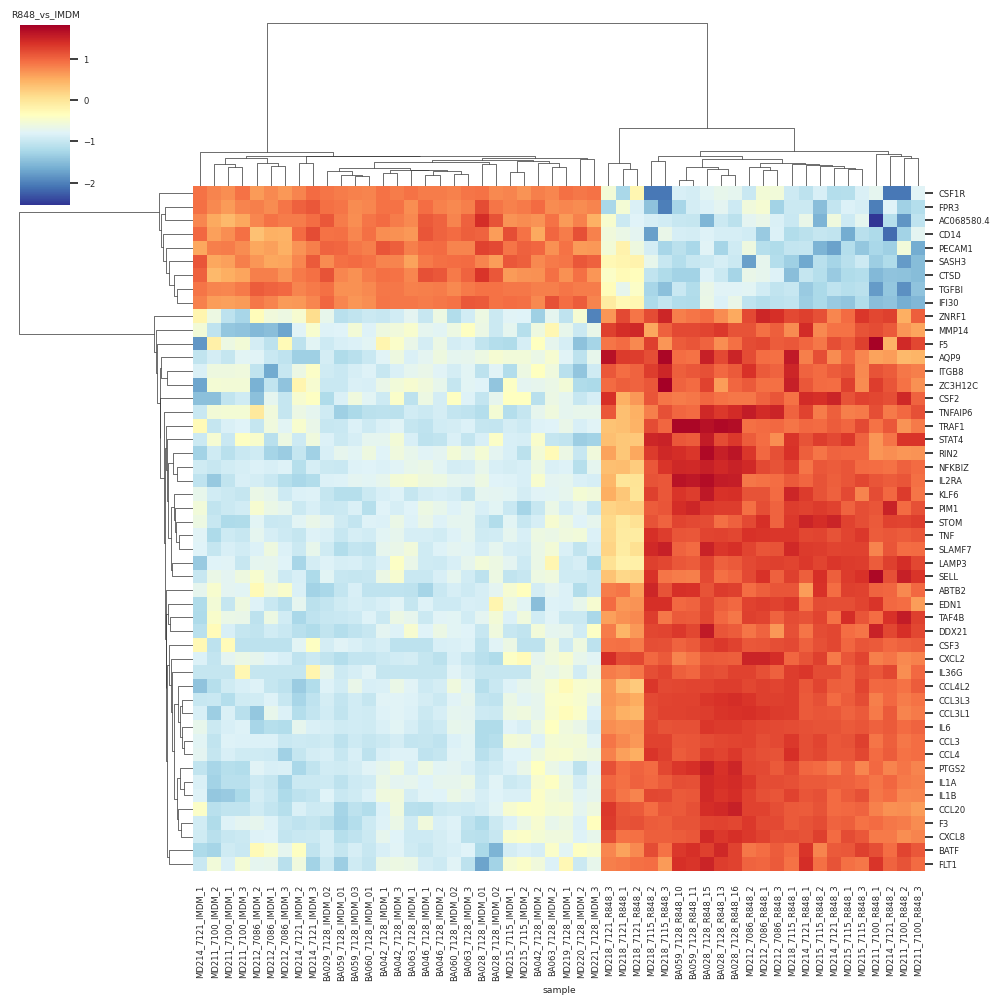

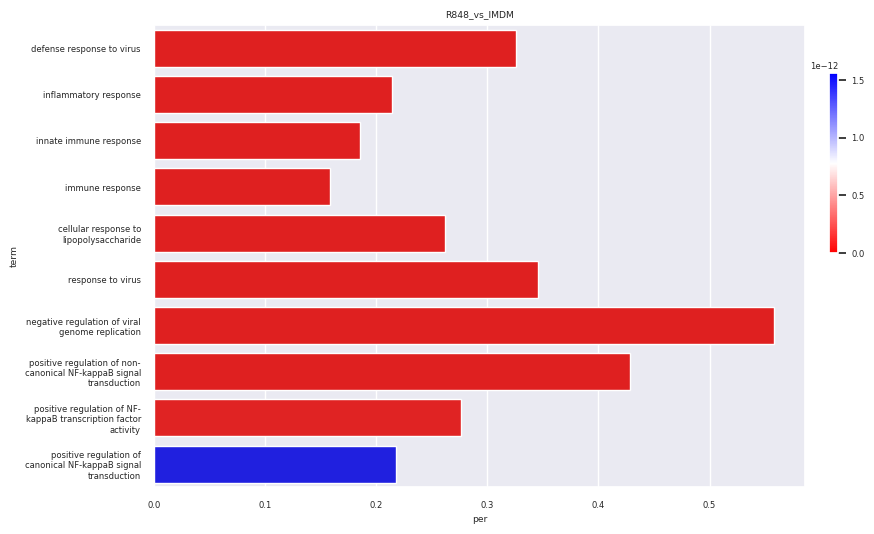

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


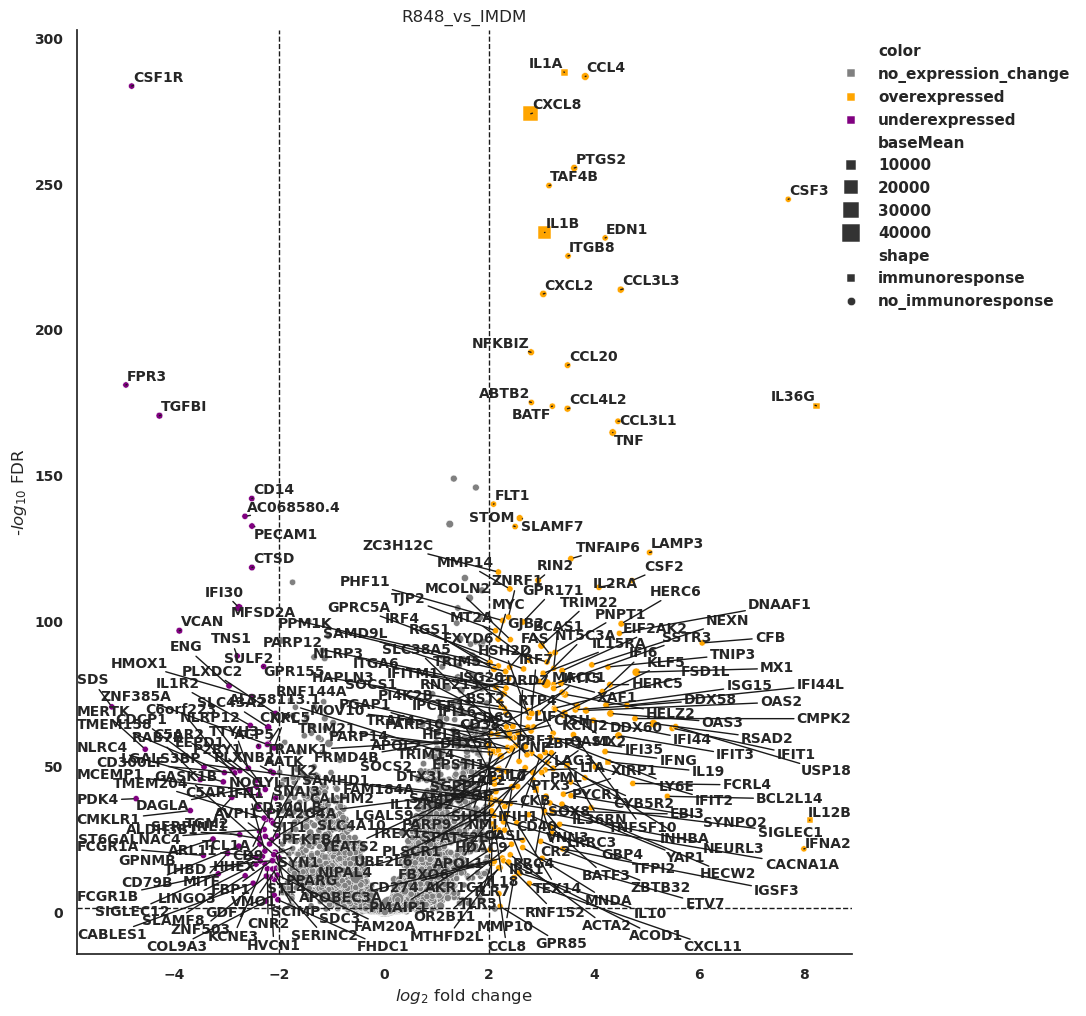

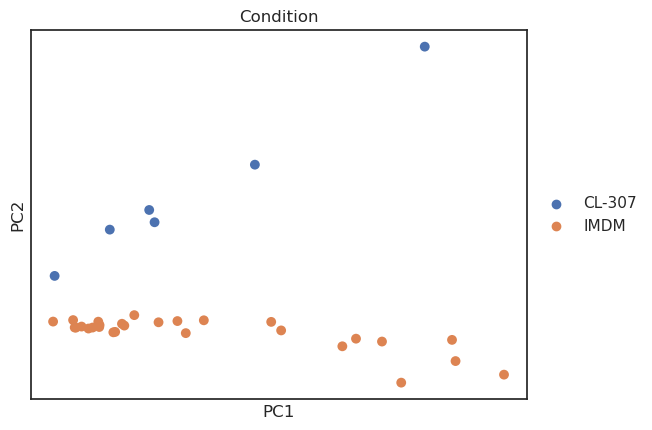

Running Wald tests...
... done in 1.19 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition CL-307 vs IMDM
           baseMean  log2FoldChange     lfcSE       stat        pvalue  \
KLHL8     80.423957        0.540143  0.136506   3.956909  7.592586e-05   
ZNF576    36.115181       -0.456333  0.164402  -2.775721  5.507951e-03   
FCF1     205.335513        0.005977  0.126954   0.047082  9.624478e-01   
TAF12     65.062011       -0.300540  0.148221  -2.027643  4.259667e-02   
GLRX      60.171732        0.637801  0.142056   4.489796  7.129147e-06   
...             ...             ...       ...        ...           ...   
TSN      295.189671        0.002319  0.080295   0.028881  9.769591e-01   
NFATC1   308.148212        0.051579  0.093154   0.553696  5.797869e-01   
PORCN     23.059800        0.182907  0.189920   0.963078  3.355086e-01   
REL     1997.104978        1.137344  0.104018  10.934130  7.916136e-28   
RPL23   2297.222159       -0.126415  0.112092  -1.127780  2.594129e-01   

                padj  
KLHL8   4.252578e-04  
ZN

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.17 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 1.21 seconds.

Fitting LFCs...
... done in 1.78 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

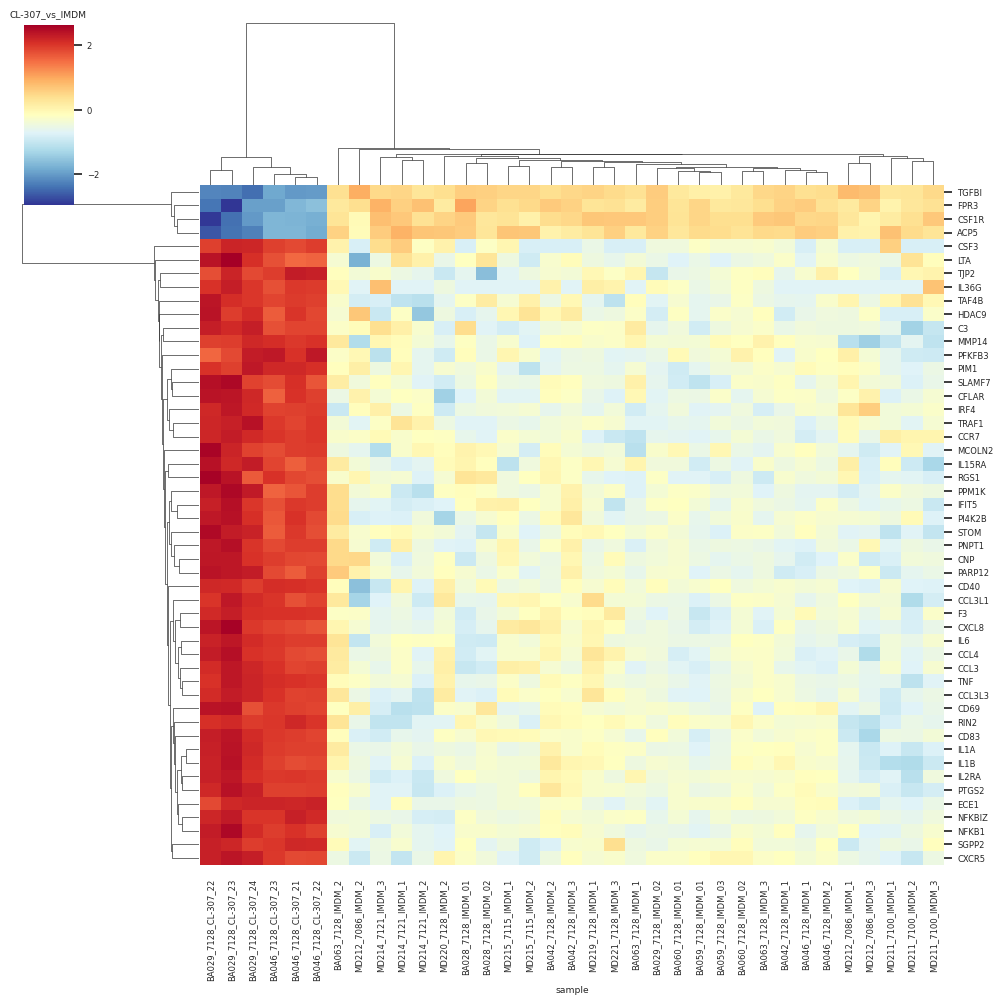

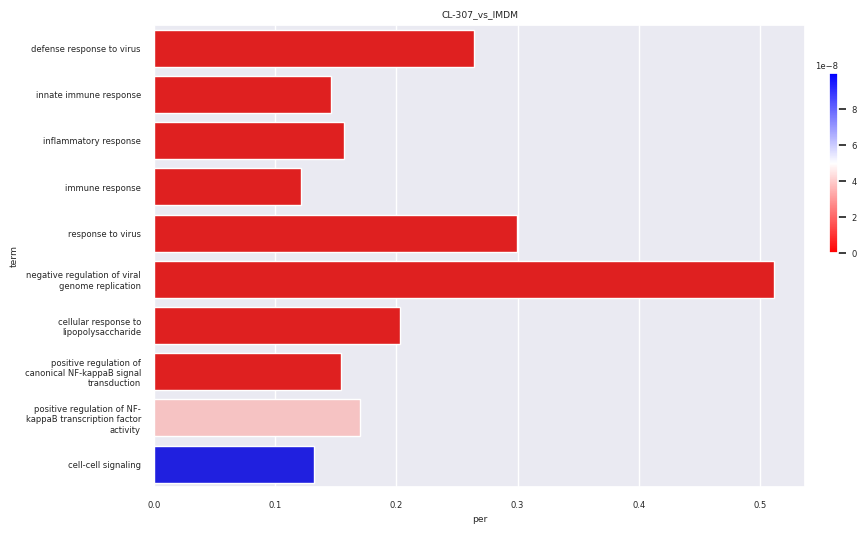

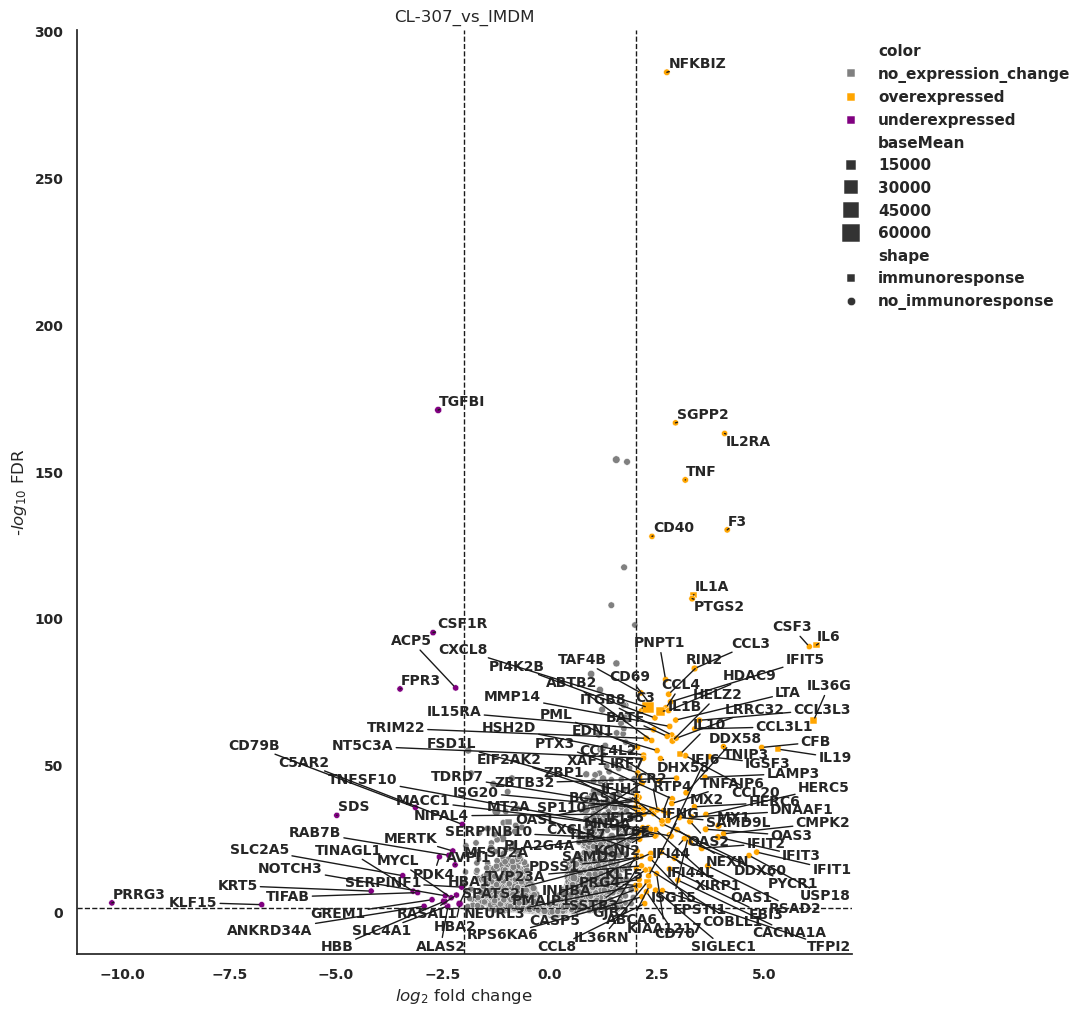

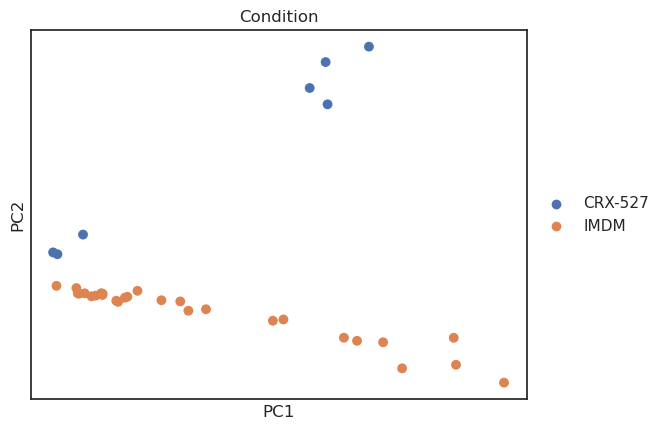

Running Wald tests...
... done in 1.05 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition CRX-527 vs IMDM
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
KLHL8     82.944819        0.671238  0.131237  5.114697  3.142457e-07   
ZNF576    35.591568       -0.266318  0.157654 -1.689256  9.117031e-02   
FCF1     204.629035        0.033216  0.121361  0.273698  7.843164e-01   
TAF12     62.712971       -0.408517  0.140970 -2.897895  3.756758e-03   
GLRX      56.443644        0.301530  0.131237  2.297595  2.158483e-02   
...             ...             ...       ...       ...           ...   
TSN      291.842431       -0.037577  0.082065 -0.457894  6.470285e-01   
NFATC1   308.711554        0.096003  0.087943  1.091649  2.749876e-01   
PORCN     23.026803        0.125266  0.180807  0.692814  4.884263e-01   
REL     1720.529087        0.316442  0.102016  3.101872  1.923012e-03   
RPL23   2335.838932        0.079939  0.107912  0.740778  4.588281e-01   

            padj  
KLHL8   0.000003  
ZNF576  0.197643  
FC

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/matplotlib/transforms.py:360: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.17 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 1.27

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

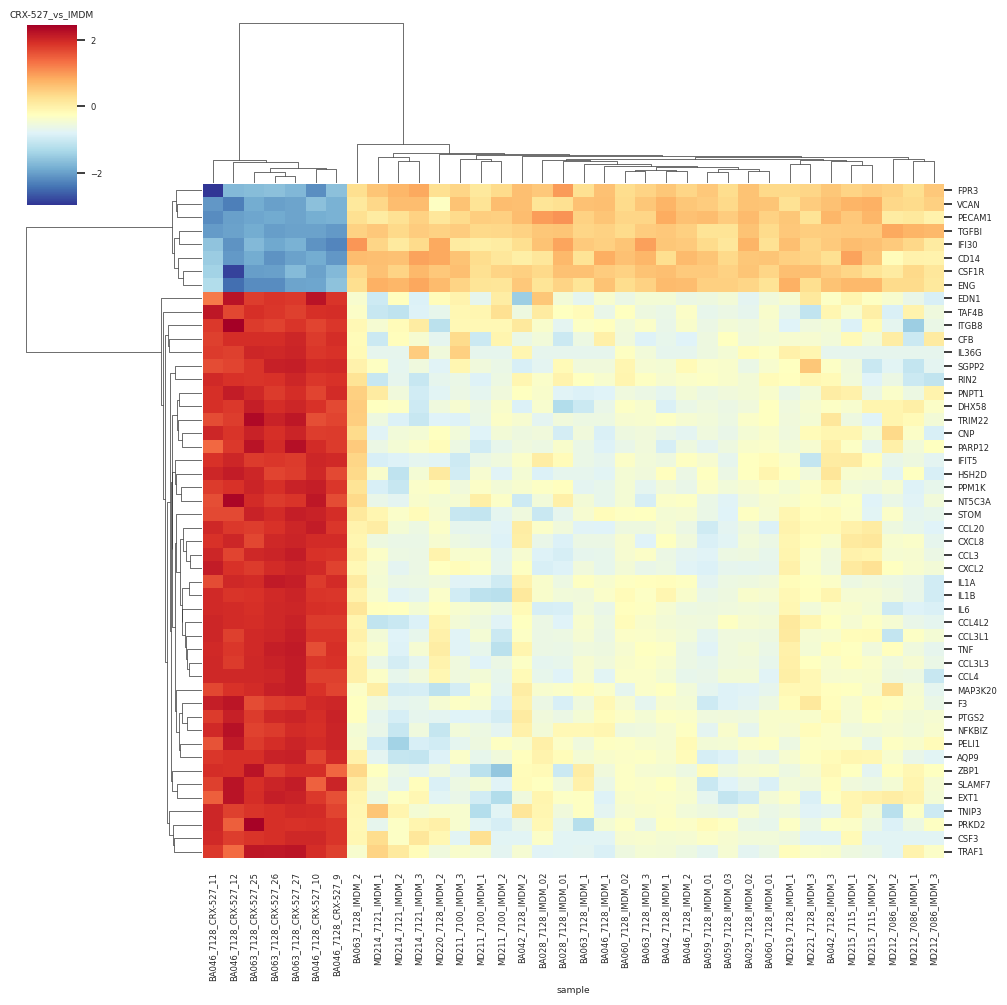

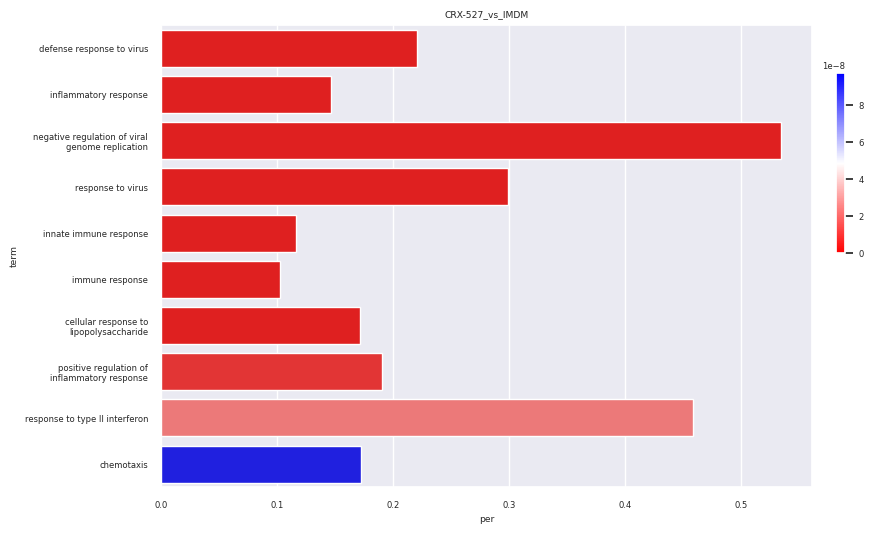

posx and posy should be finite values
posx and posy should be finite values


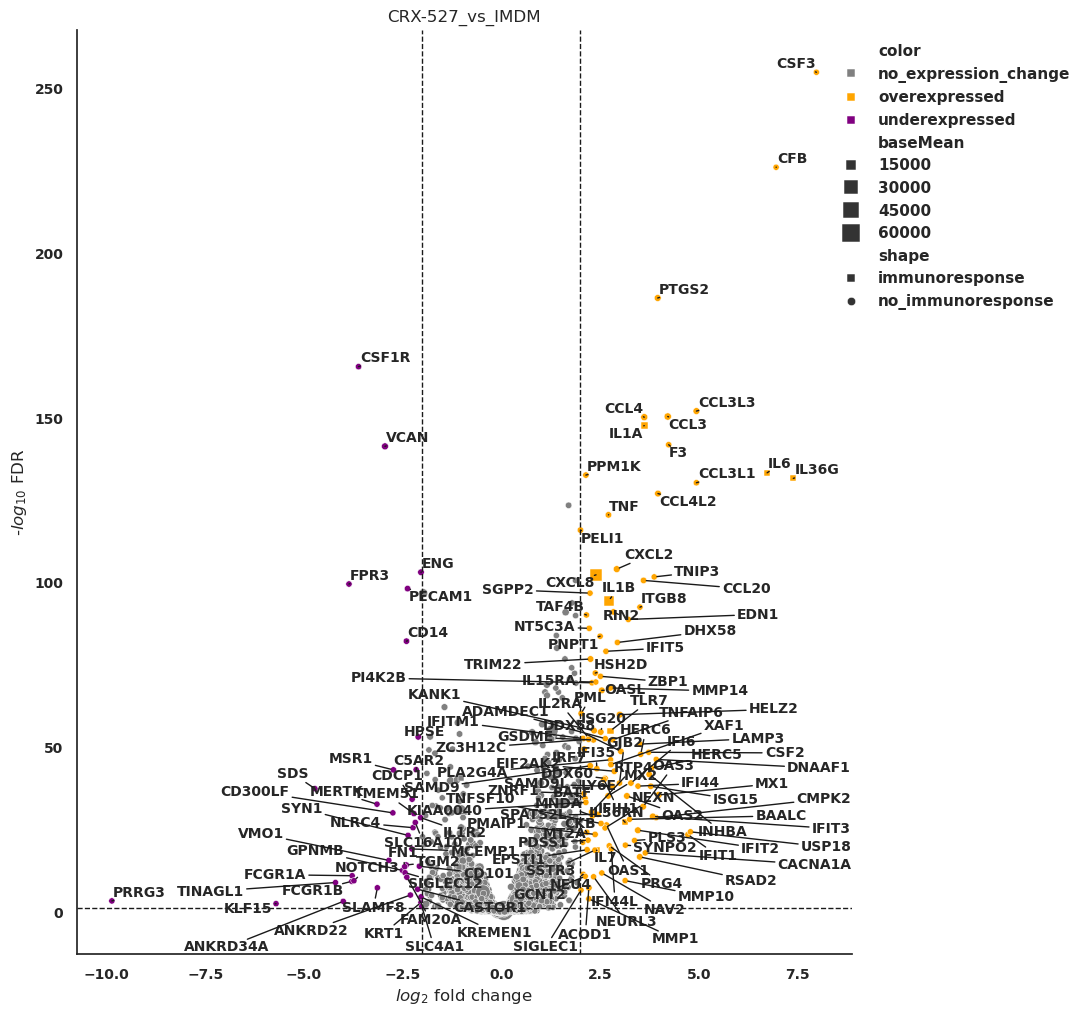

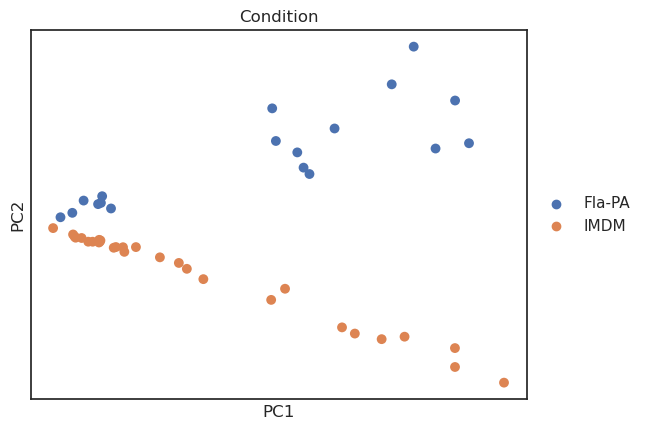

Running Wald tests...
... done in 1.07 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition Fla-PA vs IMDM
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
KLHL8     86.575089        0.394138  0.088988  4.429123  9.461713e-06   
ZNF576    40.571599        0.056746  0.097130  0.584221  5.590716e-01   
FCF1     211.770730       -0.037545  0.078135 -0.480521  6.308566e-01   
TAF12     68.636109       -0.099142  0.107213 -0.924720  3.551116e-01   
GLRX      73.593050        0.822441  0.114133  7.206000  5.761961e-13   
...             ...             ...       ...       ...           ...   
TSN      313.873904        0.062136  0.049707  1.250042  2.112841e-01   
NFATC1   329.852420        0.085159  0.086936  0.979558  3.273043e-01   
PORCN     22.107708       -0.249936  0.142586 -1.752879  7.962286e-02   
REL     1865.955006        0.265761  0.080596  3.297442  9.756983e-04   
RPL23   2455.410312        0.028587  0.076064  0.375822  7.070492e-01   

                padj  
KLHL8   5.705759e-05  
ZNF576  6.7386

/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.20 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 1.26 seconds.

Fitting LFCs...


... done in 1.68 seconds.

Refitting 10 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1200x1200 with 0 Axes>

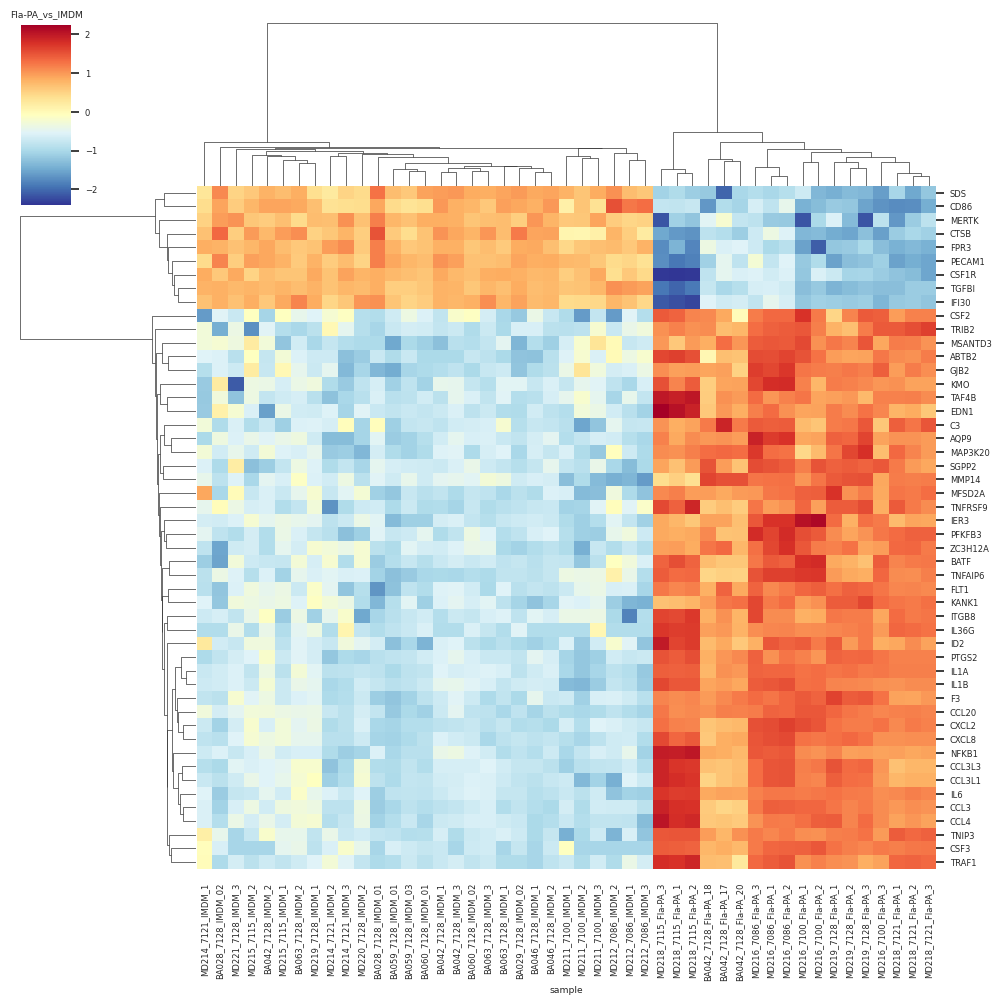

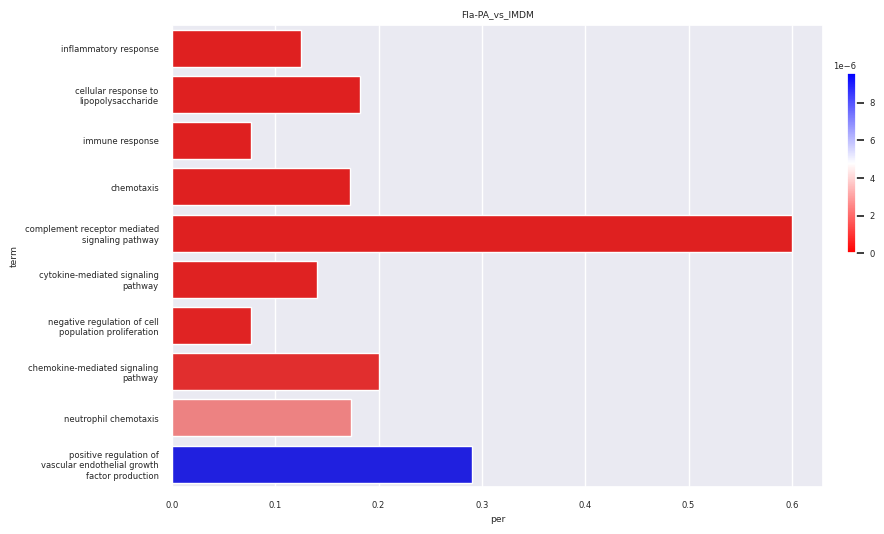

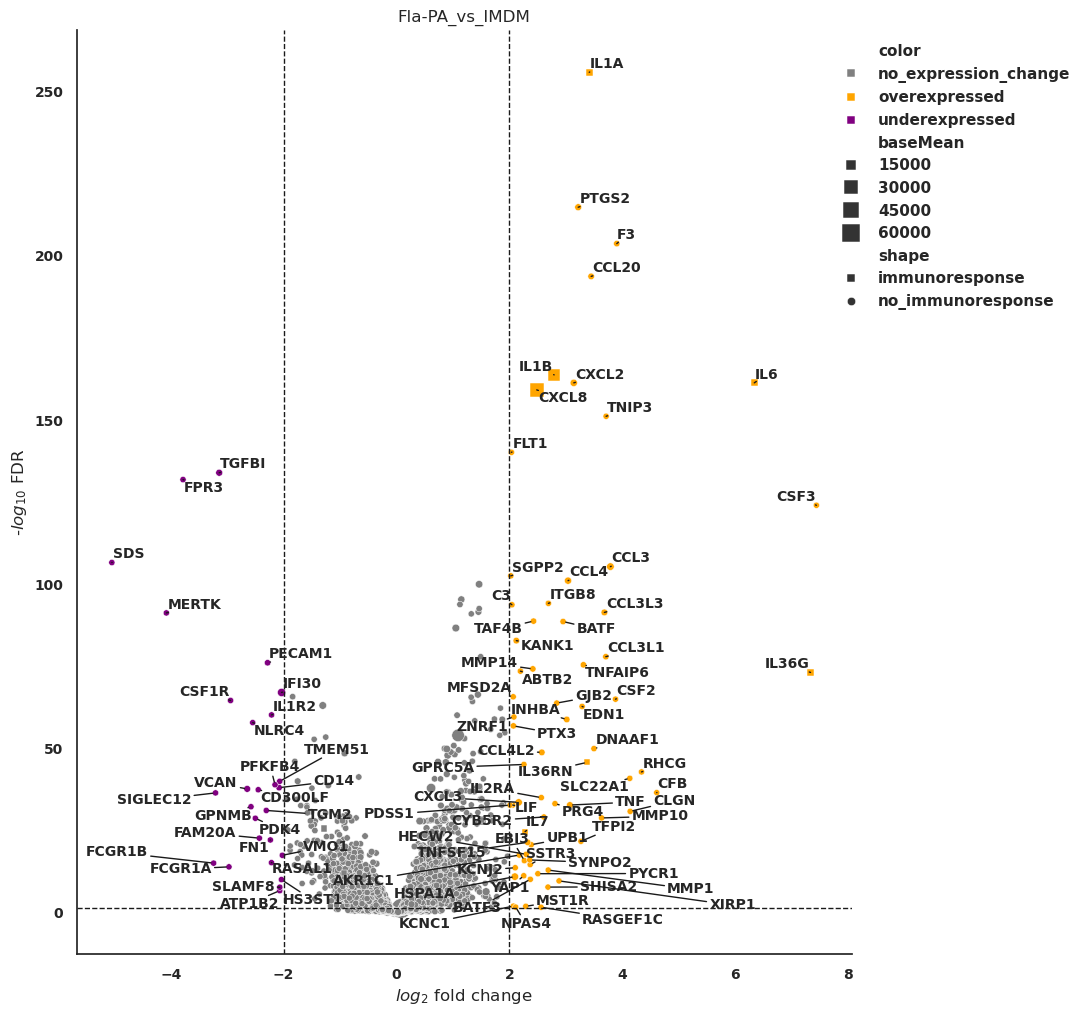

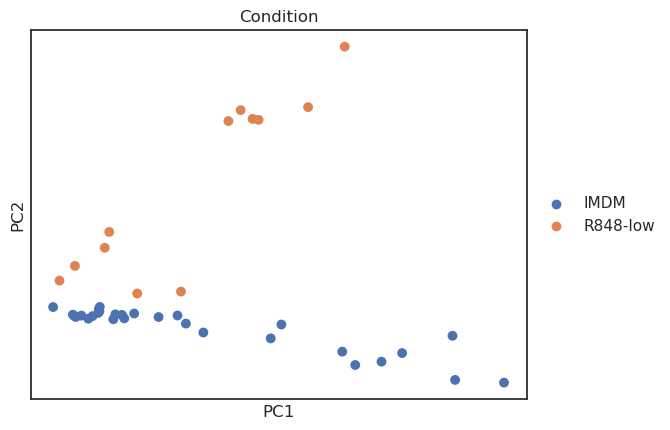

Running Wald tests...
... done in 1.17 seconds.

/tmp/ipykernel_244748/1187366467.py:8: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])


Log2 fold change & Wald test p-value: Condition R848-low vs IMDM
           baseMean  log2FoldChange     lfcSE       stat        pvalue  \
KLHL8     83.495427        0.509061  0.101956   4.992934  5.946885e-07   
ZNF576    36.378088       -0.306866  0.120635  -2.543761  1.096660e-02   
FCF1     203.802165       -0.050327  0.097966  -0.513721  6.074469e-01   
TAF12     66.511988       -0.088564  0.104047  -0.851193  3.946619e-01   
GLRX      77.719430        1.283773  0.102885  12.477797  9.867876e-36   
...             ...             ...       ...        ...           ...   
TSN      292.536732       -0.099593  0.062753  -1.587067  1.124974e-01   
NFATC1   293.353560       -0.288504  0.073734  -3.912748  9.125170e-05   
PORCN     22.455680       -0.162710  0.143527  -1.133655  2.569392e-01   
REL     1786.565979        0.315029  0.075763   4.158072  3.209445e-05   
RPL23   2403.295215        0.117253  0.083971   1.396344  1.626109e-01   

                padj  
KLHL8   3.920039e-06  


/tmp/ipykernel_244748/3625226787.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])


<Figure size 1200x1200 with 0 Axes>

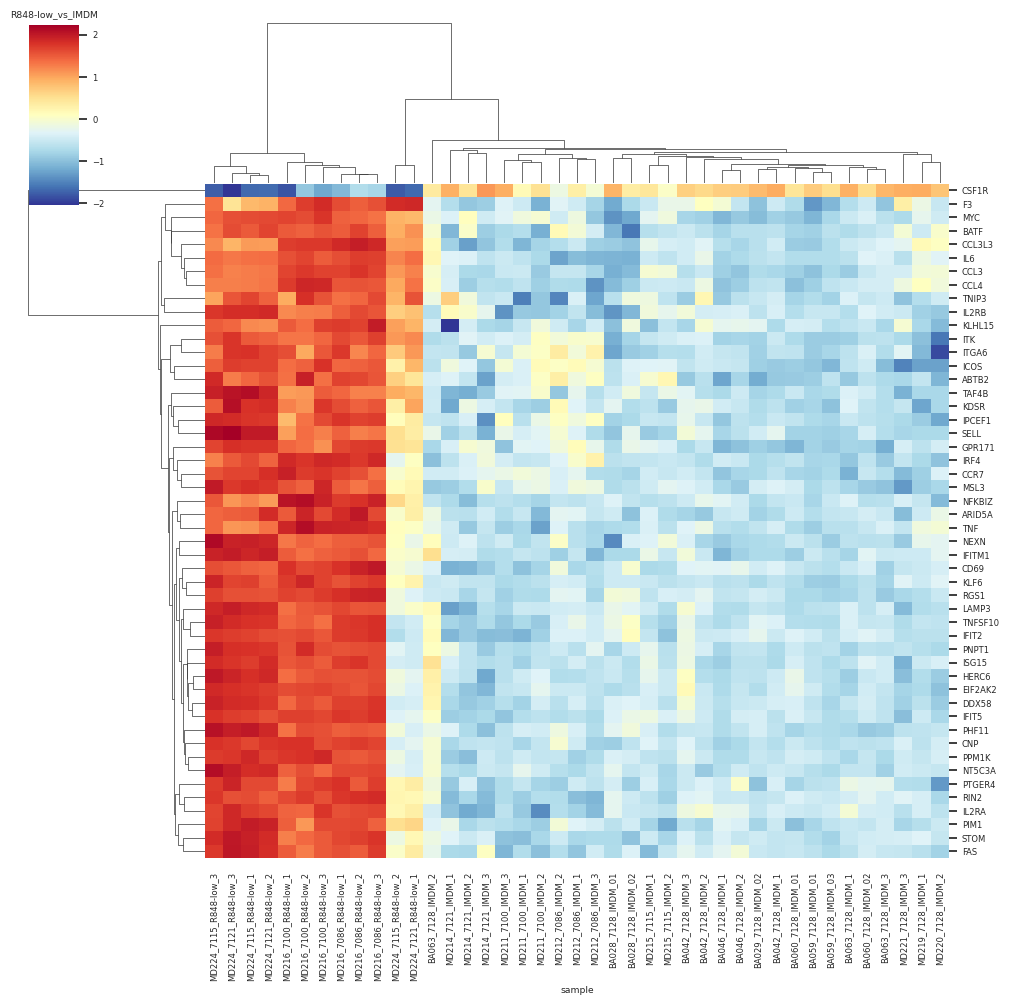

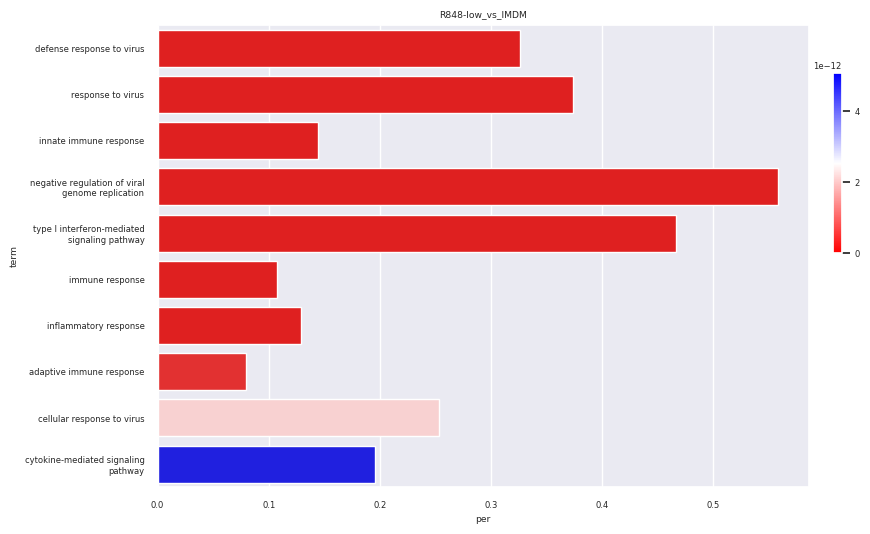

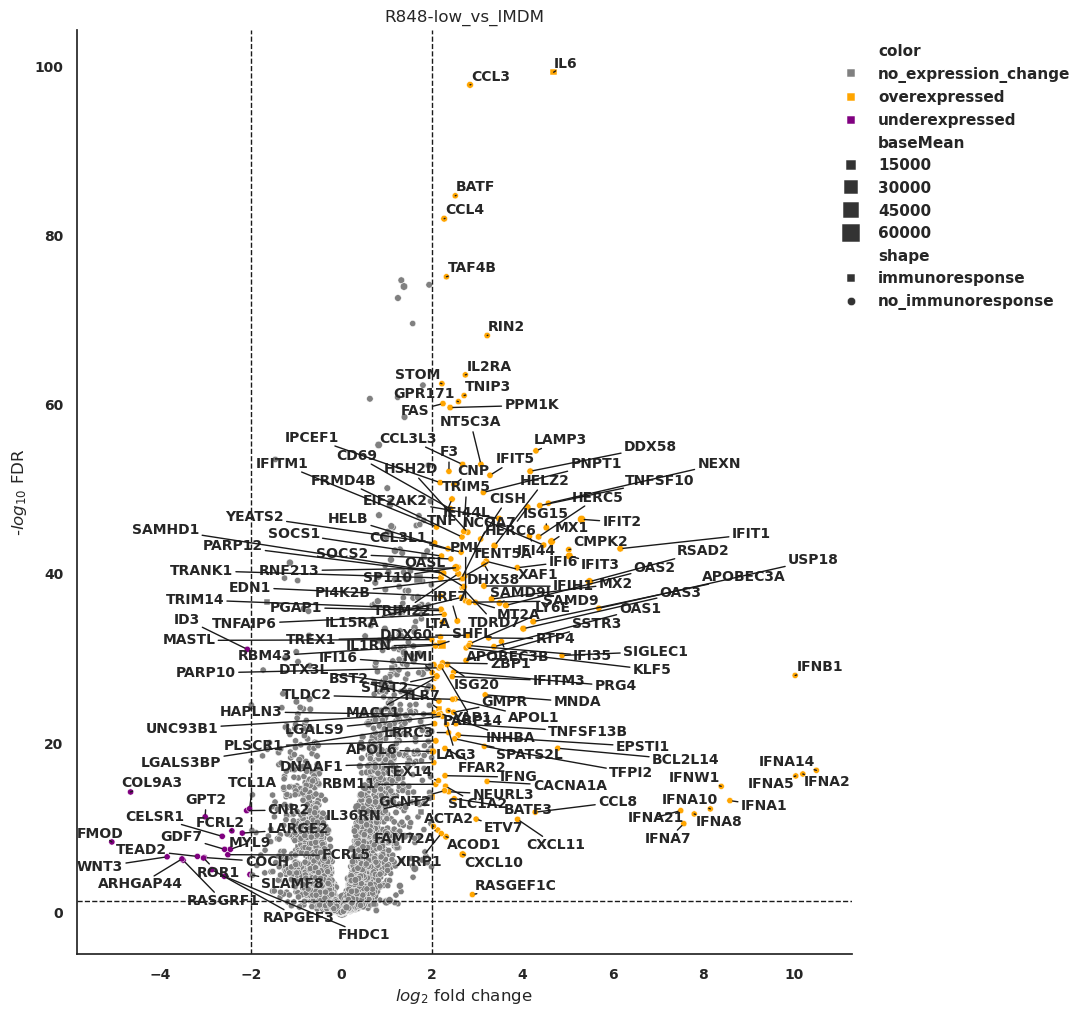

In [93]:
for class_pair in list_of_classes_to_include:
    analysis_name = f"{class_pair[0]}_vs_{class_pair[1]}"

    results_directory = os.path.join(current_directory, analysis_name)
    if not os.path.exists(results_directory):
        os.makedirs(results_directory)

    counts, metadata = prepare_counts_metadata(raw_counts, class_pair)
    dds, res, sigs = deseq(analysis_name, counts, metadata, class_pair)

    _ = make_historgram_for_sign_genes(
        dds, sigs, results_directory, analysis_name, num_top_sign=50
    )

    go_df = go_it(sigs.index, mapper, goeaobj, go_items)
    _ = make_go_plot(go_df[0:10], results_directory, analysis_name)

    _ = make_volcano_plot(res, immunoresponse_genes, results_directory, analysis_name)